In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing, model_selection
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from transformers import BertModel, BertTokenizer

from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer
import transformers

import time
import matplotlib.pyplot as plt

In [2]:
path = 'data/restaurants_laptop_train_with_pos.csv'

df = pd.read_csv(path)

# df = df[:200]

# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 3


0

In [3]:
idx = 1
print(sentences[idx])
print(aspect_tags[idx])
print(polarity_tags[idx])

['However', ',', 'the', 'multi', '-', 'touch', 'gestures', 'and', 'large', 'tracking', 'area', 'make', 'having', 'an', 'external', 'mouse', 'unnecessary', '(', 'unless', 'you', "'re", 'gaming', ')', '.']
[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]
[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = to_device(v, device)
        return data
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:

device = get_default_device()
print(device)

NUM_EPOCHS = 5
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 8
MODEL_PATH = "model.bin"
TEST_SIZE = 0.2

NUM_ASPECT_TAGS = len(encoder.classes_)
NUM_POLARITY_TAGS = len(polarity_unique_values)

# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

cuda


In [6]:
class SentenceTagDataset(Dataset):
    def __init__(self, tokenizer, sentences, aspect_tags, polarity_tags, aspect_term_tag, 
                 max_length=128):
        self.sentences = sentences
        self.aspect_tags = aspect_tags
        self.polarity_tags = polarity_tags
        self.aspect_term_tag = aspect_term_tag
        self.max_length = max_length
        self.special_token = -100

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]  # Get a sentence
        aspect_tags = self.aspect_tags[idx]  # Get the corresponding aspect tags
        polarity_tags = self.polarity_tags[idx]

        sentence_encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        word_ids = sentence_encoding.word_ids(batch_index=0)
        aspect_tags_encoding = []
        polarity_tags_encoding = []
        previous_word_idx = None
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                aspect_tags_encoding.append(self.special_token)
                polarity_tags_encoding.append(self.special_token)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                aspect_tags_encoding.append(aspect_tags[word_idx])
                if aspect_tags[word_idx] == self.aspect_term_tag:
                    polarity_tags_encoding.append(polarity_tags[word_idx])
                else:
                    polarity_tags_encoding.append(self.special_token)
            else:
                aspect_tags_encoding.append(self.special_token)
                polarity_tags_encoding.append(self.special_token)
            previous_word_idx = word_idx
        aspect_tags_encoding = torch.LongTensor(aspect_tags_encoding)
        polarity_tags_encoding = torch.LongTensor(polarity_tags_encoding)

        return {
            "input_ids": sentence_encoding["input_ids"][0],
            "attention_mask": sentence_encoding["attention_mask"][0],
            "token_type_ids": sentence_encoding["token_type_ids"][0],
            "aspect_tags": aspect_tags_encoding,
            "polarity_tags": polarity_tags_encoding,
        }
    


In [7]:
def loss_fn(output, target, mask, num_labels):
    cel = nn.CrossEntropyLoss()
    masking = mask.view(-1) == 1
    pred = output.view(-1, num_labels)
    true = torch.where(masking, target.view(-1), 
                       torch.tensor(cel.ignore_index).type_as(target))
    
    loss = cel(pred, true)
    return loss

class AspectExtractionModel(nn.Module):
    def __init__(self, num_aspect_tags, num_polarity_tags, num_vocab):
        super(AspectExtractionModel, self).__init__()
        self.num_aspect_tags = num_aspect_tags
        self.num_polarity_tags = num_polarity_tags
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-cased")        
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, self.num_aspect_tags)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(768, self.num_polarity_tags)
        # if the number of vocab has been increased, then need to add the new vector 
        # at the end of the embedding matrix
        self.bert_model.resize_token_embeddings(num_vocab)
                
    def forward(self, input_ids, attention_mask, token_type_ids, aspect_tags, polarity_tags):
        out, pool_out = self.bert_model(input_ids, attention_mask = attention_mask, 
                                 token_type_ids = token_type_ids, return_dict=False)
        
        tag_out = self.dropout1(out)
        tag_out = self.fc1(tag_out)
        
        pol_out = self.dropout2(out)
        pol_out = self.fc2(pol_out)
        
        loss_tag = loss_fn(tag_out, aspect_tags, attention_mask, self.num_aspect_tags)
        loss_pol = loss_fn(pol_out, polarity_tags, attention_mask, self.num_polarity_tags)
        loss = (loss_tag + loss_pol) / 2
        
        s = nn.Softmax(dim=2)
        
        tag_out = s(tag_out)
        pol_out = s(pol_out)
        
        return tag_out, pol_out, loss

In [8]:
def cal_acc(pred_tags, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[true_tags!=-100]
    true_tags = true_tags[true_tags!=-100]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm



In [9]:
(train_sentences, test_sentences, 
 train_aspect_tags, test_aspect_tags) = model_selection.train_test_split(
    sentences, aspect_tags, random_state = 42, test_size = TEST_SIZE)

## TODO: Need to combine the two to ensure they split the two training and test set correctly 
##
(_, _, 
 train_polarity_tags, test_polarity_tags) = model_selection.train_test_split(
    sentences, polarity_tags, random_state = 42, test_size = TEST_SIZE)

train_sentences.shape, test_sentences.shape, train_aspect_tags.shape, test_aspect_tags.shape, train_polarity_tags.shape, test_polarity_tags.shape

((2745,), (687,), (2745,), (687,), (2745,), (687,))

In [10]:
idx = 2
print(train_sentences[idx])
print(train_aspect_tags[idx])
print(train_polarity_tags[idx])

['The', 'pizza', 'was', 'pretty', 'good', 'and', 'huge', '.']
[1, 0, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 0, 0, 0, 0, 0]


In [11]:
train_dataset = SentenceTagDataset(tokenizer=tokenizer, sentences=train_sentences, 
                                   aspect_tags=train_aspect_tags,
                                   polarity_tags=train_polarity_tags,
                                   aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())
train_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE), device)    

test_dataset = SentenceTagDataset(tokenizer=tokenizer, sentences=test_sentences, 
                                  aspect_tags=test_aspect_tags,
                                  polarity_tags=test_polarity_tags,
                                  aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())
test_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE), device)   

model = to_device(AspectExtractionModel(num_aspect_tags = NUM_ASPECT_TAGS, 
                                        num_polarity_tags = NUM_POLARITY_TAGS,
                                        num_vocab = len(tokenizer)), device)

# print(model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
torch.cuda.empty_cache()

num_train_steps = int(len(train_sentences) / TRAIN_BATCH_SIZE * NUM_EPOCHS)
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=num_train_steps)

best_loss = np.inf

history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
    "polarity_valid_acc": list(),
}

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []
    final_pred_polarity_tags = []
    final_true_polarity_tags = []
    for data in tqdm(train_data_loader, total=len(train_data_loader)):
        
        optimizer.zero_grad()
        pred_aspect_tags, pred_polarity_tags, loss = model(**data)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_losses.append(loss.item())

        final_pred_aspect_tags.append(torch.argmax(pred_aspect_tags, dim=2))
        final_pred_polarity_tags.append(torch.argmax(pred_polarity_tags, dim=2))
        final_true_aspect_tags.append(data['aspect_tags'])
        final_true_polarity_tags.append(data['polarity_tags'])
        
#         print(pred_polarity_tags)
#         print(data['polarity_tags'])
        
    aspect_train_acc, aspect_train_f1, aspect_train_cm = cal_acc(final_pred_aspect_tags, 
                                                                 final_true_aspect_tags)
    polarity_train_acc, polarity_train_f1, polarity_train_cm = cal_acc(final_pred_polarity_tags, 
                                                                       final_true_polarity_tags)
        
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []
    final_pred_polarity_tags = []
    final_true_polarity_tags = []
    for data in tqdm(test_data_loader, total=len(test_data_loader)):
        pred_aspect_tags, pred_polarity_tags, loss = model(**data)
        
        test_loss.append(loss.item())
        
        final_pred_aspect_tags.append(torch.argmax(pred_aspect_tags, dim=2))
        final_pred_polarity_tags.append(torch.argmax(pred_polarity_tags, dim=2))
        final_true_aspect_tags.append(data['aspect_tags'])
        final_true_polarity_tags.append(data['polarity_tags'])

    aspect_test_acc, aspect_test_f1, aspect_test_cm = cal_acc(final_pred_aspect_tags, 
                                                              final_true_aspect_tags)
    polarity_test_acc, polarity_test_f1, polarity_test_cm = cal_acc(final_pred_polarity_tags, 
                                                                    final_true_polarity_tags)

    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_loss = sum(test_loss) / len(test_loss)
        
    print("Train Loss: {:.5f}; Valid Loss: {:.5f}".format(avg_train_loss, avg_test_loss))
    print("Aspect Train acc: {:.2f}%; Valid acc: {:.2f}%".format(
        aspect_train_acc*100, aspect_test_acc*100))
    print("Aspect Train f1: {:.2f}%; Valid f1: {:.2f}%".format(
        aspect_train_f1*100, aspect_test_f1*100))
    print("Aspect Train cm:\n {}".format(np.flip(aspect_train_cm)))
    print("Aspect Valid cm:\n {}".format(np.flip(aspect_test_cm)))
    print()
    print("Polarity Train acc: {:.2f}%; Valid acc: {:.2f}%".format(
        polarity_train_acc*100, polarity_test_acc*100))
    print("Polarity Train f1: {:.2f}%; Valid f1: {:.2f}%".format(
        polarity_train_f1*100, polarity_test_f1*100))
    print("Polarity Train cm:\n {}".format(np.flip(polarity_train_cm)))
    print("Polarity Valid cm:\n {}".format(np.flip(polarity_test_cm)))
    
    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(aspect_train_acc.cpu().numpy())
    history['polarity_train_acc'].append(polarity_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(aspect_test_acc.cpu().numpy())
    history['polarity_valid_acc'].append(polarity_test_acc.cpu().numpy())
    

100%|██████████| 86/86 [00:04<00:00, 17.66it/s]


Train Loss: 0.54413; Valid Loss: 0.37384
Aspect Train acc: 89.41%; Valid acc: 94.27%
Aspect Train f1: 88.41%; Valid f1: 94.34%
Aspect Train cm:
 [[41810  1434]
 [ 3875  3006]]
Aspect Valid cm:
 [[10793   425]
 [  319  1436]]

Polarity Train acc: 60.54%; Valid acc: 72.88%
Polarity Train f1: 60.08%; Valid f1: 72.80%
Polarity Train cm:
 [[ 780  937  113]
 [ 355 3180  157]
 [ 359  794  206]]
Polarity Valid cm:
 [[401  68  62]
 [ 77 722 110]
 [ 80  79 156]]


100%|██████████| 86/86 [00:05<00:00, 17.18it/s]


Train Loss: 0.28797; Valid Loss: 0.35233
Aspect Train acc: 95.08%; Valid acc: 95.16%
Aspect Train f1: 95.05%; Valid f1: 95.23%
Aspect Train cm:
 [[42124  1120]
 [ 1344  5537]]
Aspect Valid cm:
 [[10842   376]
 [  252  1503]]

Polarity Train acc: 81.85%; Valid acc: 75.33%
Polarity Train f1: 82.39%; Valid f1: 75.41%
Polarity Train cm:
 [[1498  137  195]
 [ 163 3347  182]
 [ 290  282  787]]
Polarity Valid cm:
 [[419  48  64]
 [ 61 721 127]
 [ 78  55 182]]


100%|██████████| 86/86 [00:05<00:00, 16.84it/s]


Train Loss: 0.17546; Valid Loss: 0.37514
Aspect Train acc: 96.13%; Valid acc: 95.14%
Aspect Train f1: 96.12%; Valid f1: 95.23%
Aspect Train cm:
 [[42348   896]
 [ 1042  5839]]
Aspect Valid cm:
 [[10814   404]
 [  227  1528]]

Polarity Train acc: 90.58%; Valid acc: 77.44%
Polarity Train f1: 91.05%; Valid f1: 78.17%
Polarity Train cm:
 [[1661   45  124]
 [  66 3510  116]
 [ 169  128 1062]]
Polarity Valid cm:
 [[390  72  69]
 [ 42 784  83]
 [ 63  67 185]]


100%|██████████| 86/86 [00:05<00:00, 16.66it/s]


Train Loss: 0.12137; Valid Loss: 0.40044
Aspect Train acc: 96.70%; Valid acc: 95.53%
Aspect Train f1: 96.69%; Valid f1: 95.57%
Aspect Train cm:
 [[42449   795]
 [  861  6020]]
Aspect Valid cm:
 [[10889   329]
 [  251  1504]]

Polarity Train acc: 94.74%; Valid acc: 77.55%
Polarity Train f1: 94.94%; Valid f1: 77.43%
Polarity Train cm:
 [[1742   21   67]
 [  36 3578   78]
 [  91   69 1199]]
Polarity Valid cm:
 [[427  57  47]
 [ 61 769  79]
 [ 84  66 165]]


100%|██████████| 86/86 [00:05<00:00, 16.49it/s]

Train Loss: 0.09506; Valid Loss: 0.41330
Aspect Train acc: 96.99%; Valid acc: 95.50%
Aspect Train f1: 96.99%; Valid f1: 95.55%
Aspect Train cm:
 [[42504   740]
 [  768  6113]]
Aspect Valid cm:
 [[10880   338]
 [  246  1509]]

Polarity Train acc: 96.47%; Valid acc: 77.21%
Polarity Train f1: 96.74%; Valid f1: 78.17%
Polarity Train cm:
 [[1770   10   50]
 [  23 3623   46]
 [  75   39 1245]]
Polarity Valid cm:
 [[375  81  75]
 [ 33 789  87]
 [ 56  68 191]]


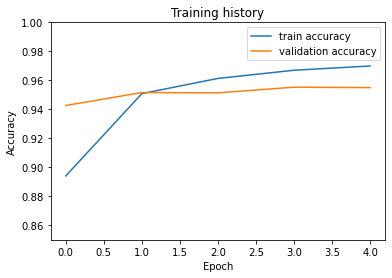

In [13]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.85, 1]);

In [14]:
def get_classification_report(test_data_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []
    final_pred_polarity_tags = []
    final_true_polarity_tags = []
    with torch.no_grad():
        for data in tqdm(test_data_loader, total=len(test_data_loader)):
            pred_aspect_tags, pred_polarity_tags, loss = model(**data)
            
            final_pred_aspect_tags.extend(torch.argmax(pred_aspect_tags, dim=2))
            final_pred_polarity_tags.extend(torch.argmax(pred_polarity_tags, dim=2))
            final_true_aspect_tags.extend(data['aspect_tags'])
            final_true_polarity_tags.extend(data['polarity_tags'])
            
    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
    
    # Remove the special -100 tokens 
    final_pred_aspect_tags = final_pred_aspect_tags[final_true_aspect_tags!=-100]
    final_true_aspect_tags = final_true_aspect_tags[final_true_aspect_tags!=-100]
    final_pred_polarity_tags = final_pred_polarity_tags[final_true_polarity_tags!=-100]
    final_true_polarity_tags = final_true_polarity_tags[final_true_polarity_tags!=-100]
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_data_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.bin


100%|██████████| 86/86 [00:05<00:00, 16.79it/s]

              precision    recall  f1-score   support

          AT       0.80      0.86      0.83      1755
         NAT       0.98      0.97      0.97     11218

    accuracy                           0.95     12973
   macro avg       0.89      0.91      0.90     12973
weighted avg       0.95      0.95      0.95     12973

              precision    recall  f1-score   support

     Neutral       0.49      0.58      0.53       315
    Positive       0.88      0.79      0.83       909
    Negative       0.75      0.79      0.77       531

    accuracy                           0.75      1755
   macro avg       0.70      0.72      0.71      1755
weighted avg       0.77      0.75      0.76      1755



In [ ]:
def random_test(test_dataset, test_data_loader, model, num=5, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)
    
    with torch.no_grad():
        for i in range(num):
            
            data = next(iter(test_data_loader))
            
            pred_aspect_tags, pred_polarity_tags, _ = model(**data)
            
            
            input_ids = data['input_ids']
            pred_aspect_tags = torch.argmax(pred_aspect_tags, dim=2)
            pred_polarity_tags = torch.argmax(pred_polarity_tags, dim=2)
            true_aspect_tags = data['aspect_tags']
            true_polarity_tags = data['polarity_tags']
            mask = data['attention_mask']
            
            # Randomly pick a test data from this batch
            #
            rng = np.random.default_rng()
            idx = rng.integers(low=0, high=pred_aspect_tags.shape[0],size=1)[0]
#             idx = np.random.randint(0,pred_aspect_tags.shape[0],size=1)[0]

            ids_array = input_ids[idx].cpu().numpy()
            pred_aspect_array = pred_aspect_tags[idx].cpu().numpy()
            true_aspect_array = true_aspect_tags[idx].cpu().numpy()
            pred_polarity_array = pred_polarity_tags[idx].cpu().numpy()
            true_polarity_array = true_polarity_tags[idx].cpu().numpy()
            mask_array = mask[idx].cpu().numpy()

            # Remove the padding as we do not want to print them
            #
            mask_array = np.logical_not(mask_array)

            # Only print the unpadded portion
            ids_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, ids_array))
            pred_aspect_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                       pred_aspect_array))
            true_aspect_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                       true_aspect_array))
            pred_polarity_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                         pred_polarity_array))
            true_polarity_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                         true_polarity_array))
            
            aspect_pred = pred_aspect_unpadded[true_aspect_unpadded!=-100]
            aspect_true = true_aspect_unpadded[true_aspect_unpadded!=-100]
            polarity_pred = pred_polarity_unpadded[true_polarity_unpadded!=-100]
            polarity_true = true_polarity_unpadded[true_polarity_unpadded!=-100]
            
            aspect_acc = np.sum(aspect_pred == aspect_true) / len(aspect_pred)
            polarity_acc = np.sum(polarity_pred == polarity_true) / len(polarity_pred)
            
            # Remove begin and end
            ids_unpadded = ids_unpadded[1:-1]
            pred_aspect_unpadded = pred_aspect_unpadded[1:-1]
            true_aspect_unpadded = true_aspect_unpadded[1:-1]
            pred_polarity_unpadded = pred_polarity_unpadded[1:-1]
            true_polarity_unpadded = true_polarity_unpadded[1:-1]
            
            true_aspect_unpadded = np.where(true_aspect_unpadded==-100, 1, true_aspect_unpadded)

            # let's replace 2 back to -1 for presentation
            pred_polarity_unpadded = np.where(pred_polarity_unpadded == 2, -1, 
                                              pred_polarity_unpadded)
            true_polarity_unpadded = np.where(true_polarity_unpadded == 2, -1, 
                                              true_polarity_unpadded)
            
            orig_sentence = np.array(tokenizer.convert_ids_to_tokens(ids_unpadded))
            decoded_aspect_tags = encoder.inverse_transform(true_aspect_unpadded)
            aspect_tag_indices = decoded_aspect_tags == "AT"
            
            pred_polarity_unpadded = pred_polarity_unpadded[aspect_tag_indices]
            true_polarity_unpadded = true_polarity_unpadded[aspect_tag_indices]

            print("Aspect Acc: {:.2f}%".format(aspect_acc*100))
            print("Polarity Acc: {:.2f}%".format(polarity_acc*100))
            print("Predicted Aspect:")
            print(encoder.inverse_transform(pred_aspect_unpadded))
            print("True Aspect:")
            print(decoded_aspect_tags)
            print("Predicted Polarity:")
            print(pred_polarity_unpadded)
            print("True Polarity:")
            print(true_polarity_unpadded)
            print("Sentence:")
            print(orig_sentence)   
            print("Aspect Terms: {}".format(orig_sentence[aspect_tag_indices]))
            print()


In [ ]:
random_test(test_dataset, test_data_loader, model, num=10, model_path=MODEL_PATH)


In [ ]:
def test_dataset(idx=0):


    train_dataset = SentenceTagDataset(tokenizer=tokenizer,
                                       sentences=train_sentences,
                                       aspect_tags=train_aspect_tags,
                                       polarity_tags=train_polarity_tags,
                                       aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())

    train_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
        train_dataset, batch_size=32), device)    

    data = train_dataset[idx]
    input_ids = data['input_ids']
    attention_mask = np.logical_not(data['attention_mask'])
    aspect_tags = data['aspect_tags']
    polarity_tags = data['polarity_tags']
    
    print("*** Raw Data")
    print("*** input_ids")
    print(input_ids)
    print("*** aspect_tags")
    print(aspect_tags)
    print("*** polarity_tags")
    print(polarity_tags)
    print()
    
    input_ids = np.ma.compressed(np.ma.masked_where(attention_mask, input_ids))
    aspect_tags = np.ma.compressed(np.ma.masked_where(attention_mask, aspect_tags))
    polarity_tags = np.ma.compressed(np.ma.masked_where(attention_mask, polarity_tags))
    
#     input_ids = input_ids[(input_ids!=101) & (input_ids!=102)]
    
    aspect_tags = np.where(aspect_tags==-100, 1, aspect_tags)
#     polarity_tags = np.where(polarity_tags==-100, 0, polarity_tags)
    
#     aspect_tags = aspect_tags[aspect_tags!=-100]
    polarity_tags = polarity_tags[polarity_tags!=-100]
    
    orig_sentence = np.array(train_dataset.tokenizer.convert_ids_to_tokens(input_ids))
    decoded_aspect_tags = encoder.inverse_transform(aspect_tags)
    
    aspect_tag_indices = decoded_aspect_tags == "AT"
    
    print(orig_sentence)
    print(decoded_aspect_tags)  
    print(polarity_tags)  
    
    print("Aspect Terms: {}".format(orig_sentence[aspect_tag_indices]))

test_dataset(1)